# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [3]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [4]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [7]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(66, 6)


,title,price,year,link,brand,age
0,chevy hhr lt,10800,NaN,https://charlottesville.craigslist.org/cto/d/s...,chevy,NaN
1,lincoln continental mark vi,11500,NaN,https://charlottesville.craigslist.org/cto/d/w...,missing,NaN
2,for sale - used loaded 2005 gmc yukon denali,3750,2005.0,https://charlottesville.craigslist.org/cto/d/e...,gmc,20.0
3,1985 chevrolet 3/4 ton 4x4 short bed,26500,1985.0,https://charlottesville.craigslist.org/cto/d/s...,chevrolet,40.0
4,1957 chevrolet bel air 2 door hardtop,19500,1957.0,https://charlottesville.craigslist.org/cto/d/w...,chevrolet,68.0


With the data in and wrangled, we can now do some analysis:

count       66.000000
mean     10115.833333
std      10634.789623
min       2000.000000
25%       3425.000000
50%       6500.000000
75%      11375.000000
max      62800.000000
Name: price, dtype: float64


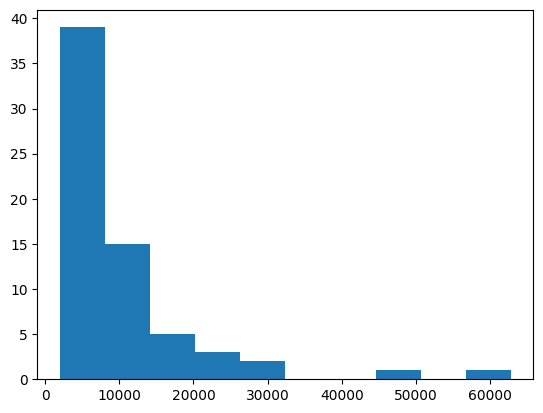

count    59.000000
mean     22.338983
std      14.808677
min       4.000000
25%      13.000000
50%      18.000000
75%      24.500000
max      68.000000
Name: age, dtype: float64


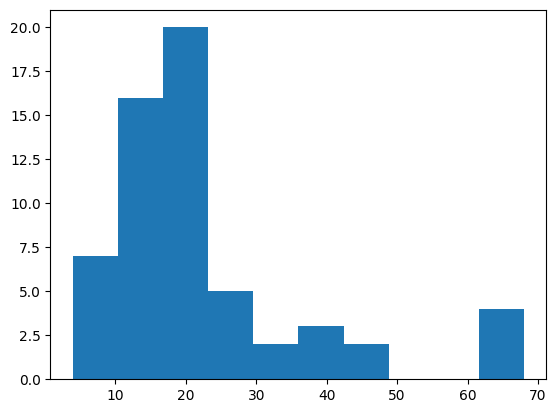

In [6]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [8]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                         \
           count          mean           std      min      25%      50%   
brand                                                                     
acura        2.0   5250.000000   3181.980515   3000.0   4125.0   5250.0   
audi         1.0  11000.000000           NaN  11000.0  11000.0  11000.0   
bmw          3.0   9333.333333   1607.275127   7500.0   8750.0  10000.0   
cadillac     1.0   2950.000000           NaN   2950.0   2950.0   2950.0   
chevrolet    3.0  20166.666667   6027.713773  14500.0  17000.0  19500.0   
chevy        5.0   4980.000000   3566.791275   2200.0   2900.0   3000.0   
dodge        2.0   6875.000000   4065.863992   4000.0   5437.5   6875.0   
ford         6.0  18833.333333  15980.196077   4000.0  10500.0  15750.0   
gmc          3.0  12250.000000  12018.215342   3750.0   5375.0   7000.0   
honda       10.0   9040.000000   8027.065328   3000.0   3725.0   6200.0   
jeep         2.0   7475.000000   1732.411614   6250.0   6862.5   7475.0   
kia          1.0   2500.000000           NaN   2500.0   2500.0   2500.0   
lexus        2.0   7423.000000   4987.931234   3896.0   5659.5   7423.0   
missing     13.0  10111.538462  16931.862885   2000.0   3200.0   3500.0   
mitsubishi   1.0   6800.000000           NaN   6800.0   6800.0   6800.0   
subaru       1.0   5999.000000           NaN   5999.0   5999.0   5999.0   
tesla        1.0  25000.000000           NaN  25000.0  25000.0  25000.0   
toyota       6.0   8558.333333   4654.290136   3000.0   5525.0   8225.0   
volkswagen   3.0   7666.666667   5788.854233   2550.0   4525.0   6500.0   

                              
                75%      max  
brand                         
acura        6375.0   7500.0  
audi        11000.0  11000.0  
bmw         10250.0  10500.0  
cadillac     2950.0   2950.0  
chevrolet   23000.0  26500.0  
chevy        6000.0  10800.0  
dodge        8312.5   9750.0  
ford        18375.0  49500.0  
gmc         16500.0  26000.0  
honda       11725.0  29000.0  
jeep         8087.5   8700.0  
kia          2500.0   2500.0  
lexus        9186.5  10950.0  
missing      5250.0  62800.0  
mitsubishi   6800.0   6800.0  
subaru       5999.0   5999.0  
tesla       25000.0  25000.0  
toyota      10512.5  16000.0  
volkswagen  10225.0  13950.0

In [9]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                      
           count       mean        std   min    25%   50%    75%   max
brand                                                                 
acura        2.0  15.000000   5.656854  11.0  13.00  15.0  17.00  19.0
audi         1.0   8.000000        NaN   8.0   8.00   8.0   8.00   8.0
bmw          3.0  15.666667   1.527525  14.0  15.00  16.0  16.50  17.0
cadillac     1.0  19.000000        NaN  19.0  19.00  19.0  19.00  19.0
chevrolet    3.0  48.000000  17.435596  36.0  38.00  40.0  54.00  68.0
chevy        2.0  23.500000   3.535534  21.0  22.25  23.5  24.75  26.0
dodge        2.0  26.500000   6.363961  22.0  24.25  26.5  28.75  31.0
ford         6.0  19.666667   7.941452  11.0  14.00  19.5  22.00  33.0
gmc          2.0  30.500000  14.849242  20.0  25.25  30.5  35.75  41.0
honda       10.0  13.800000   5.788878   4.0  11.25  14.0  15.75  25.0
jeep         2.0  15.500000   3.535534  13.0  14.25  15.5  16.75  18.0
kia          1.0  17.000000        NaN  17.0  17.00  17.0  17.00  17.0
lexus        2.0  17.000000   5.656854  13.0  15.00  17.0  19.00  21.0
missing     10.0  35.100000  22.859231   7.0  18.75  26.0  58.00  68.0
mitsubishi   1.0  17.000000        NaN  17.0  17.00  17.0  17.00  17.0
subaru       1.0  10.000000        NaN  10.0  10.00  10.0  10.00  10.0
tesla        1.0   7.000000        NaN   7.0   7.00   7.0   7.00   7.0
toyota       6.0  18.333333   4.885352  12.0  14.75  19.0  21.00  25.0
volkswagen   3.0  25.333333  17.243356  10.0  16.00  22.0  33.00  44.0

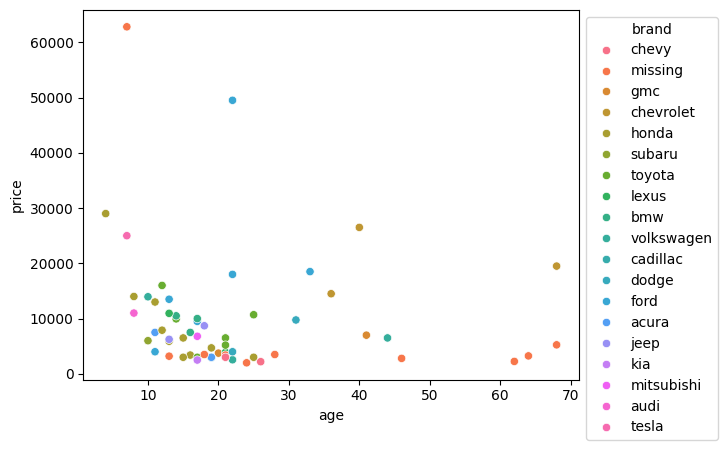

In [10]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   0.652415 -0.145888
log_age    -0.145888  0.336253
           log_price   log_age
log_price   1.000000 -0.312438
log_age    -0.312438  1.000000


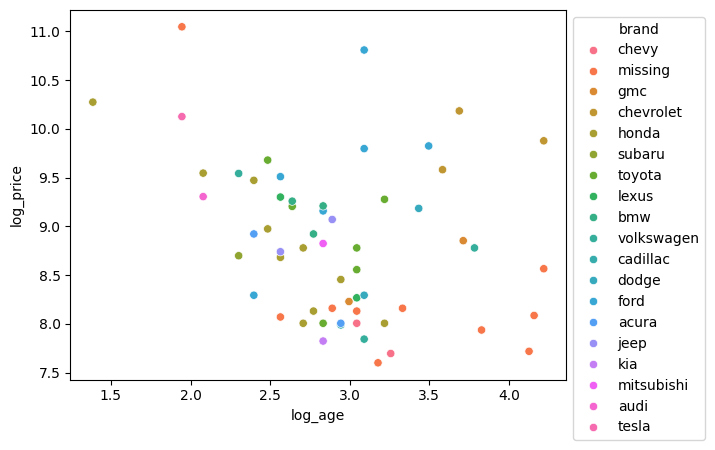

In [11]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.

In [12]:
# Electronics on craigslist: https://charlottesville.craigslist.org/search/jwa?purveyor=owner#search=1~gallery~0~0

In [13]:
header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/ela#search=1~gallery~0~6' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

In [14]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

In [15]:
import re # Regular expressions

brands = ['apple', 'samsung','lg','sony','nokia','motorola','huawei','oneplus','google','xiaomi', 'vizio', 'onkyo',
            'bose', 'jbl', 'harman', 'beats', 'fitbit', 'garmin', 'canon', 'nikon', 'sony', 'panasonic', 'fujifilm',
            'ring', 'nest', 'arlo', 'dji', 'gopro', 'denon', 'insignia']

types = ['phone', 'tablet', 'laptop', 'desktop', 'monitor', 'tv', 'headphones', 'speaker', 'camera', 'drone', 'smartwatch',
         'fitness tracker', 'game console', 'sound system', 'smart home', 'projector', 'printer', 'router', 'modem', 'stereo',
         'keyboard', 'mouse', 'remote control', 'charging cable', 'thermostat', 'antenna', 'cable', 'cables', 'remote', 'airpods',
         'air pods', 'dock', 'television', 'ipad', 'iphone', 'battery', 'hdtv', 'radio', 'watch', 'speakers', ]


data = []
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get type of electronics from title string:
    words = title.split()
    hits = [word for word in words if word in types] # Find type in the title
    if len(hits) == 0:
        type = 'missing'
    else:
        type = hits[0]

    #
    data.append({'title':title,'price':price,'type':type,'link':link,'brand':brand})

In [16]:
# Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
print(df.shape)
df.to_csv('craigslist_cville_electronics.csv') # Save data in case of a disaster
df.head(20)

(149, 5)


,title,price,type,link,brand
0,"remote control for sceptre tv e505bv-fmqk, fmqc",10,remote,https://charlottesville.craigslist.org/ele/d/f...,missing
1,turntable console record player with cd player...,200,missing,https://charlottesville.craigslist.org/ele/d/n...,missing
2,samsung surround sound speakers,75,speakers,https://charlottesville.craigslist.org/ele/d/c...,samsung
3,niles audio ssvc-4 speaker selection/volume co...,175,speaker,https://charlottesville.craigslist.org/ele/d/c...,missing
4,cyber acoustics powered sub-woofer and control...,25,missing,https://charlottesville.craigslist.org/ele/d/c...,missing
5,sony model ss-ts102 speakers,20,speakers,https://charlottesville.craigslist.org/ele/d/c...,sony
6,kanexpro 1x2 hdmi splitter,30,missing,https://charlottesville.craigslist.org/ele/d/c...,missing
7,onkyo - the unifier - universal programmable r...,20,remote,https://charlottesville.craigslist.org/ele/d/c...,onkyo
8,sangean wfr-28 internet radio - like new condi...,75,radio,https://charlottesville.craigslist.org/ele/d/c...,missing
9,onkyo powered sub woofer and surrounds,150,missing,https://charlottesville.craigslist.org/ele/d/c...,onkyo


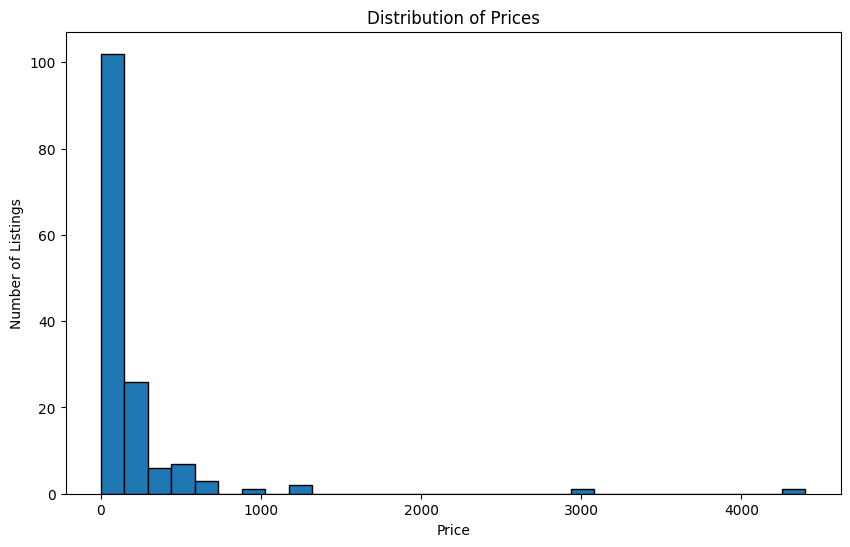

In [17]:
# Plot histogram of prices
plt.figure(figsize=(10, 6))
plt.hist(df['price'], bins=30, edgecolor='black')
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Number of Listings')
plt.show()

In [18]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                              
           count        mean         std    min     25%    50%     75%     max
brand                                                                         
apple        9.0  117.111111  148.425440   10.0   50.00   75.0   95.00   499.0
beats        1.0   50.000000         NaN   50.0   50.00   50.0   50.00    50.0
bose         1.0   75.000000         NaN   75.0   75.00   75.0   75.00    75.0
canon        3.0   75.000000   87.891979   10.0   25.00   40.0  107.50   175.0
denon        2.0  412.500000  265.165043  225.0  318.75  412.5  506.25   600.0
fitbit       1.0   80.000000         NaN   80.0   80.00   80.0   80.00    80.0
garmin       1.0   40.000000         NaN   40.0   40.00   40.0   40.00    40.0
insignia     1.0   40.000000         NaN   40.0   40.00   40.0   40.00    40.0
lg           1.0   60.000000         NaN   60.0   60.00   60.0   60.00    60.0
missing    107.0  230.233645  541.005294    0.0   30.00   75.0  200.00  4400.0
nest         2.0   32.500000    3.535534   30.0   31.25   32.5   33.75    35.0
onkyo        4.0  103.750000   60.190669   20.0   80.00  122.5  146.25   150.0
panasonic    2.0   50.000000   35.355339   25.0   37.50   50.0   62.50    75.0
samsung      3.0   53.333333   20.207259   35.0   42.50   50.0   62.50    75.0
sony         5.0   48.000000   19.557607   20.0   45.00   50.0   50.00    75.0
vizio        6.0   99.666667  148.938466    8.0   35.00   37.5   70.00   400.0

In [19]:
# Price by type:
df.loc[:,['price','type']].groupby('type').describe()

price                                                             \
           count         mean         std     min      25%     50%      75%   
type                                                                          
airpods      4.0    88.750000   42.890364    50.0    68.75    77.5    97.50   
battery      1.0   200.000000         NaN   200.0   200.00   200.0   200.00   
cable        4.0    32.500000    9.574271    20.0    27.50    35.0    40.00   
cables       2.0    22.500000   10.606602    15.0    18.75    22.5    26.25   
camera       5.0   236.800000  231.114041    40.0    49.00   120.0   475.00   
hdtv         5.0    44.000000   17.464249    35.0    35.00    35.0    40.00   
headphones   1.0    50.000000         NaN    50.0    50.00    50.0    50.00   
iphone       1.0  3000.000000         NaN  3000.0  3000.00  3000.0  3000.00   
laptop       1.0   170.000000         NaN   170.0   170.00   170.0   170.00   
missing     50.0   252.020000  642.995493     0.0    35.00    77.5   218.75   
modem        1.0    15.000000         NaN    15.0    15.00    15.0    15.00   
monitor      1.0   125.000000         NaN   125.0   125.00   125.0   125.00   
phone        1.0    25.000000         NaN    25.0    25.00    25.0    25.00   
printer      5.0   124.000000  117.334991    10.0    35.00   100.0   175.00   
projector    2.0   100.000000  140.007143     1.0    50.50   100.0   149.50   
radio        5.0    64.000000   53.080128    15.0    30.00    50.0    75.00   
remote       3.0    16.666667    5.773503    10.0    15.00    20.0    20.00   
router       4.0    71.250000  102.824689    10.0    17.50    25.0    78.75   
speaker      7.0    71.428571   52.338186    30.0    35.00    50.0    87.50   
speakers    16.0   262.500000  333.826302    20.0    50.00   162.5   280.00   
stereo       5.0   111.000000   56.833089    50.0    80.00   100.0   125.00   
tablet       1.0   450.000000         NaN   450.0   450.00   450.0   450.00   
television   1.0    50.000000         NaN    50.0    50.00    50.0    50.00   
thermostat   2.0    32.500000    3.535534    30.0    31.25    32.5    33.75   
tv          18.0   139.055556  196.016648     0.0    41.25    50.0   100.00   
watch        3.0   248.000000  219.104998    95.0   122.50   150.0   324.50   

                    
               max  
type                
airpods      150.0  
battery      200.0  
cable         40.0  
cables        30.0  
camera       500.0  
hdtv          75.0  
headphones    50.0  
iphone      3000.0  
laptop       170.0  
missing     4400.0  
modem         15.0  
monitor      125.0  
phone         25.0  
printer      300.0  
projector    199.0  
radio        150.0  
remote        20.0  
router       225.0  
speaker      175.0  
speakers    1300.0  
stereo       200.0  
tablet       450.0  
television    50.0  
thermostat    35.0  
tv           700.0  
watch        499.0

In [20]:
# Price by brand and type:
df.loc[:,['price','brand','type']].groupby(['brand','type']).describe()

price                                                    \
                     count         mean         std     min      25%     50%   
brand     type                                                                 
apple     airpods      3.0    68.333333   16.072751    50.0    62.50    75.0   
          router       1.0    10.000000         NaN    10.0    10.00    10.0   
          tv           2.0    47.500000    3.535534    45.0    46.25    47.5   
          watch        3.0   248.000000  219.104998    95.0   122.50   150.0   
beats     headphones   1.0    50.000000         NaN    50.0    50.00    50.0   
bose      missing      1.0    75.000000         NaN    75.0    75.00    75.0   
canon     camera       1.0    40.000000         NaN    40.0    40.00    40.0   
          printer      2.0    92.500000  116.672619    10.0    51.25    92.5   
denon     missing      1.0   225.000000         NaN   225.0   225.00   225.0   
          speakers     1.0   600.000000         NaN   600.0   600.00   600.0   
fitbit    missing      1.0    80.000000         NaN    80.0    80.00    80.0   
garmin    cable        1.0    40.000000         NaN    40.0    40.00    40.0   
insignia  missing      1.0    40.000000         NaN    40.0    40.00    40.0   
lg        tv           1.0    60.000000         NaN    60.0    60.00    60.0   
missing   airpods      1.0   150.000000         NaN   150.0   150.00   150.0   
          battery      1.0   200.000000         NaN   200.0   200.00   200.0   
          cable        3.0    30.000000   10.000000    20.0    25.00    30.0   
          cables       2.0    22.500000   10.606602    15.0    18.75    22.5   
          camera       4.0   286.000000  234.692707    49.0   102.25   297.5   
          hdtv         1.0    40.000000         NaN    40.0    40.00    40.0   
          iphone       1.0  3000.000000         NaN  3000.0  3000.00  3000.0   
          laptop       1.0   170.000000         NaN   170.0   170.00   170.0   
          missing     42.0   280.619048  698.657596     0.0    31.25    87.5   
          modem        1.0    15.000000         NaN    15.0    15.00    15.0   
          monitor      1.0   125.000000         NaN   125.0   125.00   125.0   
          phone        1.0    25.000000         NaN    25.0    25.00    25.0   
          printer      3.0   145.000000  138.112273    35.0    67.50   100.0   
          projector    2.0   100.000000  140.007143     1.0    50.50   100.0   
          radio        5.0    64.000000   53.080128    15.0    30.00    50.0   
          remote       2.0    15.000000    7.071068    10.0    12.50    15.0   
          router       3.0    91.666667  115.578256    20.0    25.00    30.0   
          speaker      6.0    75.000000   56.391489    30.0    32.50    57.5   
          speakers    12.0   287.916667  358.129346    45.0    57.50   180.0   
          stereo       4.0   113.750000   65.239942    50.0    72.50   102.5   
          tablet       1.0   450.000000         NaN   450.0   450.00   450.0   
          tv          10.0   177.500000  237.571627     0.0    27.50    75.0   
nest      thermostat   2.0    32.500000    3.535534    30.0    31.25    32.5   
onkyo     missing      2.0   147.500000    3.535534   145.0   146.25   147.5   
          remote       1.0    20.000000         NaN    20.0    20.00    20.0   
          stereo       1.0   100.000000         NaN   100.0   100.00   100.0   
panasonic hdtv         1.0    75.000000         NaN    75.0    75.00    75.0   
          missing      1.0    25.000000         NaN    25.0    25.00    25.0   
samsung   hdtv         1.0    35.000000         NaN    35.0    35.00    35.0   
          speakers     1.0    75.000000         NaN    75.0    75.00    75.0   
          television   1.0    50.000000         NaN    50.0    50.00    50.0   
sony      missing      1.0    75.000000         NaN    75.0    75.00    75.0   
          speaker      1.0    50.000000         NaN    50.0    50.00    50.0   
          speakers   

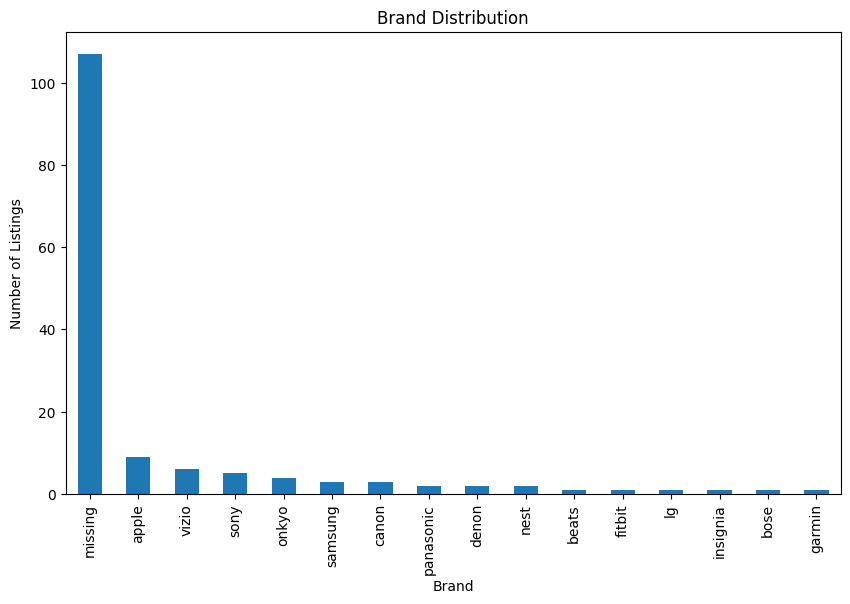

In [21]:
# Bar plot of brand distribution
brand_counts = df['brand'].value_counts()
plt.figure(figsize=(10, 6))
brand_counts.plot(kind='bar')
plt.title('Brand Distribution')
plt.xlabel('Brand')
plt.ylabel('Number of Listings')
plt.show()

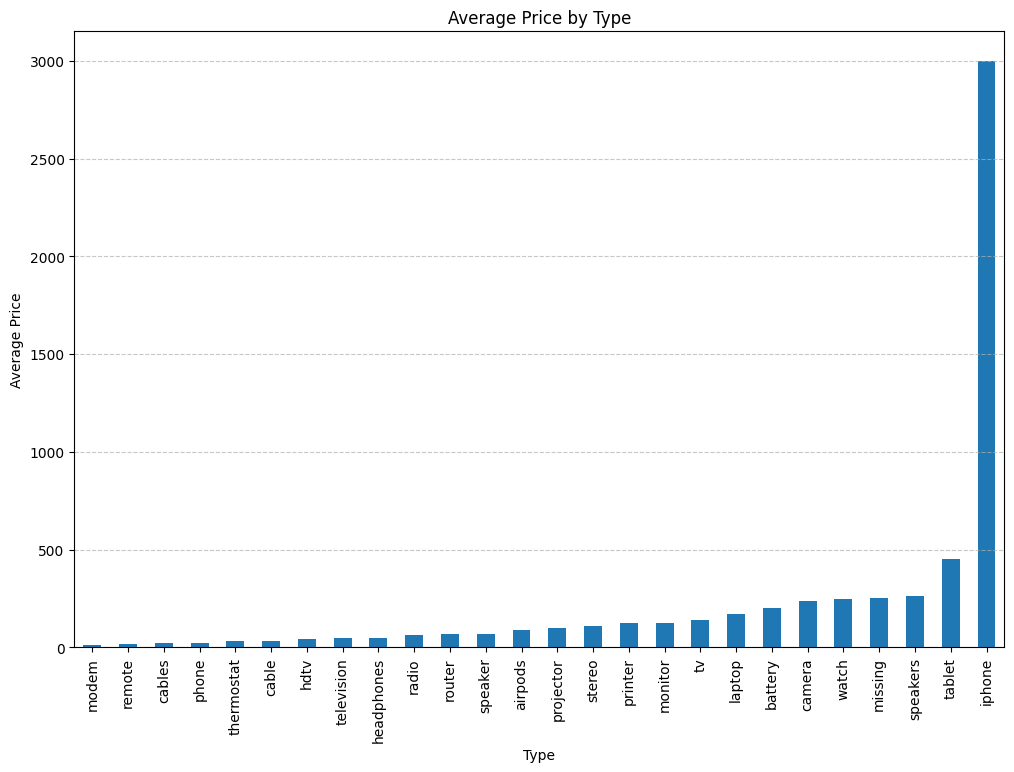

In [36]:
# Average price by type of electronic
plt.figure(figsize=(12, 8))
df.groupby('type')['price'].mean().sort_values().plot(kind='bar')
plt.xticks(rotation=90)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.title('Average Price by Type')
plt.xlabel('Type')
plt.ylabel('Average Price')
plt.show()

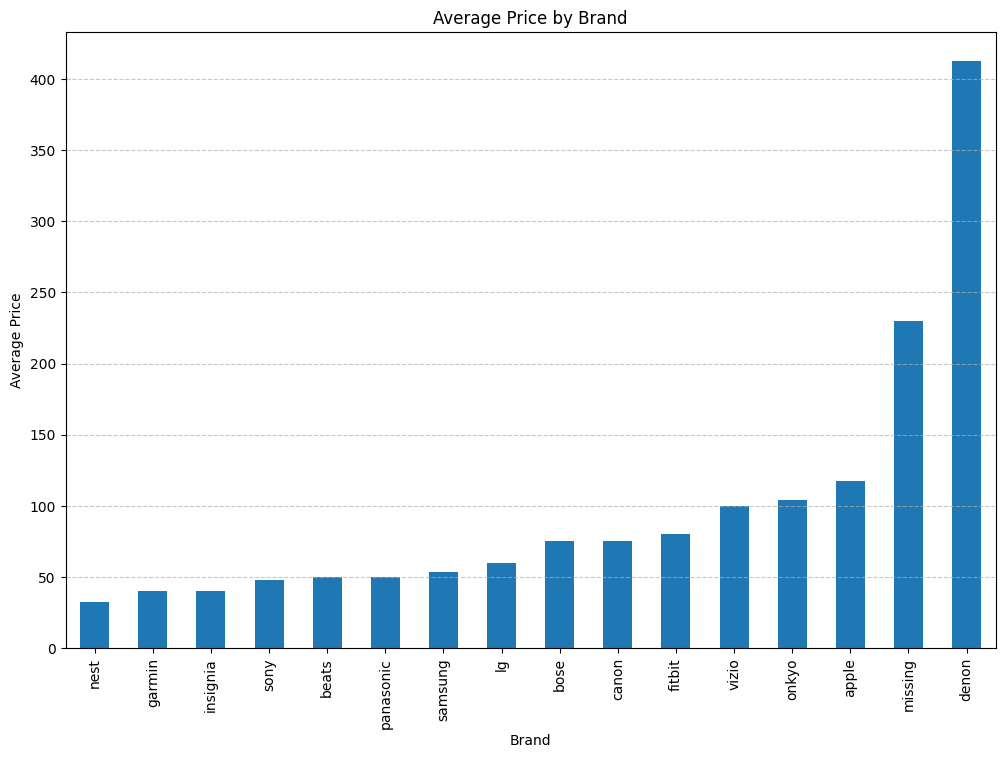

In [35]:
# Average price by brand of electronic
plt.figure(figsize=(12, 8))
df.groupby('brand')['price'].mean().sort_values().plot(kind='bar')
plt.xticks(rotation=90)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.title('Average Price by Brand')
plt.xlabel('Brand')
plt.ylabel('Average Price')
plt.show()

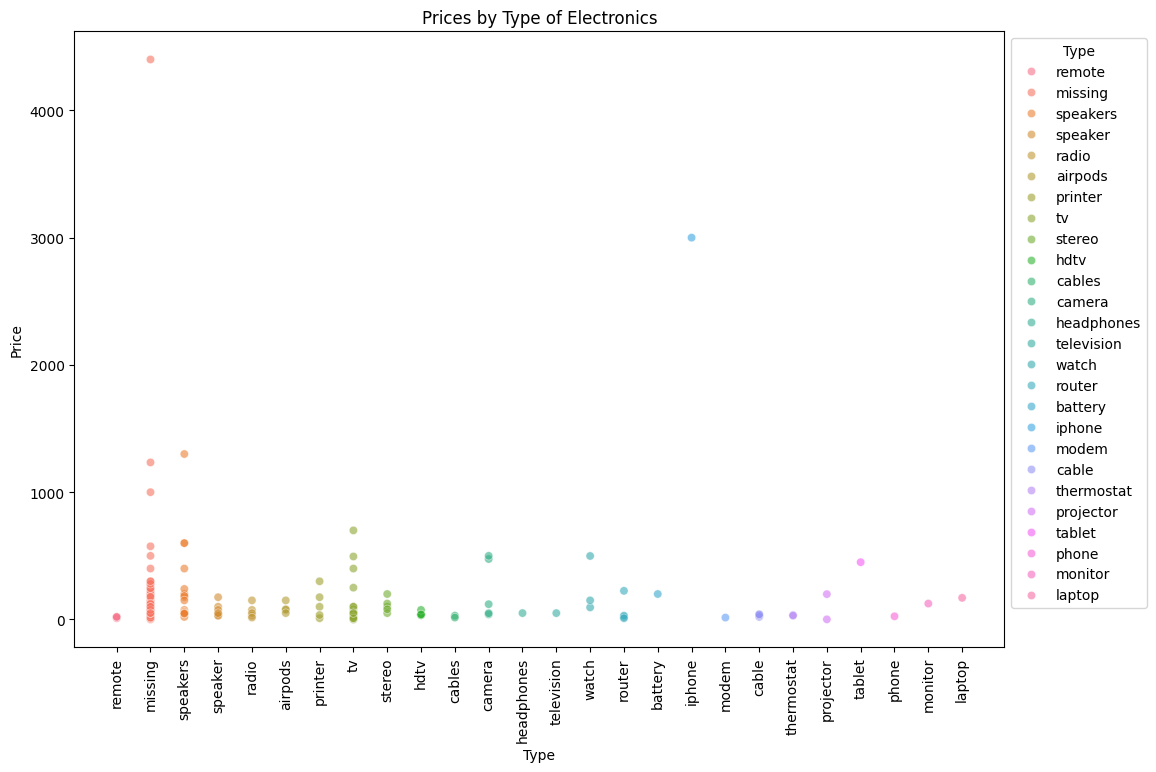

In [29]:
# Scatter plot of prices by type
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='type', y='price', hue='type', alpha=0.6)

plt.title('Prices by Type of Electronics')
plt.xlabel('Type')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.legend(title='Type', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()